##### U-Net architecture

See [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19) for code and [here](https://arxiv.org/pdf/1505.04597.pdf) for the original literature.

In [1]:
# from __future__ import print_function # presumably for compatibility with python 2?
%reset
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Lambda, Input, merge, Activation, Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU,PReLU
from keras.optimizers import Adam, Adagrad, RMSprop, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
# "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols)

import pickle
from matplotlib import pyplot as plt

#from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import make_scorer

# from data import load_train_data, load_test_data # These must be custom functions

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


### Helper functions

In [2]:
def np_jaccard(y_true,y_pred,smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true * np.rint(y_pred))
    return (intersection+smooth) / (np.sum(y_true) + np.sum(y_pred) - intersection+smooth)

In [3]:
def norm_preds(preds):
    for i in range(preds.shape[0]):
        preds[i,0,:,:] = (preds[i,0,:,:].min() - preds[i,0,:,:])/(preds[i,0,:,:].min()-preds[i,0,:,:].max())
    return preds

In [4]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_subplot(221)
    ax1.imshow(preds[i,0,...],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(np.rint(preds[i,0,...]),cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,17,...],cmap='Greys')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y[i,classType,:,:],cmap='spectral')
    
    plt.show()
#plot_all(2,2,classType,0.5)
#push('PICTURES!','The plots are ready')

In [5]:
# Load the components of the pushbullet API

from pushbullet import Pushbullet

pb = Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL')
phone = pb.devices[0]

In [6]:
# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [7]:
# Import the training data
def import_data(load_whitened = False, normalize = True):
    if load_whitened:
        with open('./data/x_whitened_resized_array.pickle','rb') as f:
            x = pickle.load(f)
            x = x.astype('float32')
    else:
        with open('./data/x_resized_array.pickle','rb') as f:
            x = pickle.load(f)
            x = x.astype('float32')
            # Normalize data to max values
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    x[i,j,:,:] *= 1/x[i,j,:,:].max()
                    
    # Normalize values between 1 and 0
    if normalize:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                #x[i,j,:,:] /= x[i,j,:,:].max()
                x[i,j,:,:] = (x[i,j,:,:].min() - x[i,j,:,:])/(x[i,j,:,:].min() - x[i,j,:,:].max())

    with open('./data/y_resized_raster.pickle','rb') as f:
        y = pickle.load(f)
        y = y.astype(np.float32)
        
    y_oneclass = y[:,1:6,...]
    
    '''
    Classes:
    0 Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    1 Misc. Manmade structures 
    2 Road 
    3 Track - poor/dirt/cart track, footpath/trail
    4 Trees - woodland, hedgerows, groups of trees, standalone trees
    5 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    6 Waterway 
    7 Standing water
    8 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    9 Vehicle Small - small vehicle (car, van), motorbike
    '''
    
    return x, y, y_oneclass
    
    # Just use a single class: roads
    #y = y[:,4,:,:]
    #y = y[:,np.newaxis,:,:]

    # y = y.reshape(y.shape[0],-1)
    # x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [8]:
# Import the training data
# This is the new version. It needs to be tested.
def import_data(exposure = False, aligned = False):
    if exposure:
        x = np.load('./data/x_train_exposure.npy','r')
    elif aligned:
        np.load('./data/x_train_exposure_aligned.npy','r')
    else:
        x = np.load('./data/x_train_norm.npy','r')
        
    with open('./data/y_resized_raster.pickle','rb') as f:
        y = pickle.load(f)
        y = y.astype(np.float32)
        
    y_oneclass = y[:,1:6,...]
    
    '''
    Classes:
    0 Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    1 Misc. Manmade structures 
    2 Road 
    3 Track - poor/dirt/cart track, footpath/trail
    4 Trees - woodland, hedgerows, groups of trees, standalone trees
    5 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    6 Waterway 
    7 Standing water
    8 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    9 Vehicle Small - small vehicle (car, van), motorbike
    '''
    
    return x, y, y_oneclass

In [9]:
run = 37

### Notes and thoughts

#### Current best ideas / runs that work / etc.
- Batch size = 5 seems to make all the difference
- Currently working with one class (3) and all 25 images (no validation!)
- nfilters is only 16

#### Ideas
- NB to add validation
- Trying with a second class (4) which is "tracks" - this is very similar to roads so might train well, accordingly.
- Try a third class that is distinct, eg. trees or crops (5 and 6, respectively)
- Potentially try with lower nfilters (4? 8?  and higher nfilters (32? 64?) to see if these affect performance significantly. I suspect that more classes might need more filters in order to store more information.
- Weight map: sum the total area of all classes in y, then calculate each class' proportion of the total and use `1-value` in place of 1 in the binary mask. This will cause low frequency classes to contribute more to the total loss, i.e. penalizing the model when it fails to predict low frequency classes.

#### Data augmentation / image manipulation
- [Histogram Equalization](http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py) (also see [here](https://www.kaggle.com/gabrielaltay/dstl-satellite-imagery-feature-detection/exploring-color-scaling-images/discussion), [here](http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/) and [here](https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc#.x9nidcsh6))

In [10]:
%%time
'''
V2.0 U-Net with batchnorm
'''
x, y, y_oneclass = import_data()

def builder(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1.0,decay=0.0,momentum=0.0, nesterov=False):
    
    '''def dice_coef(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)'''

    def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred) # This rounds to the nearest integer, i.e. > 0.5 = 1
        # y_pred_f = K.flatten(y_pred) # Original version
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_loss(y_true, y_pred):
        return -jaccard(y_true, y_pred)
    
    '''
    This function computes the sigmoid activation of the matrix, then divides each activation by the sum: i.e. a softmax
    Subsequently this is returned.
    To use, simple add a Lambda layer calling this function:
    
    keras.layers.core.Lambda(function, output_shape=None, arguments=None)
    '''
    
    '''def depth_softmax(matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix
        
    def Conv2DReluBatchNormSoftmax(n_filter, w_filter, h_filter, inputs, init='he_uniform',dropout=0.2):
        return BatchNormalization(mode=0, axis=1)(Lambda(depth_softmax)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init)(inputs)))
        
    '''
    
    '''
    As an alternative, I could reshape the last tensor to (n_images, classes) where each n_image has size width*height,
    then compare to masks that are also flattened.
    
    '''
    
    def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs, activation='relu',init='he_uniform',dropout=0.2):
        return BatchNormalization(mode=0, axis=1)(Activation(activation=activation)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init)(inputs)))
        #return Activation(activation=activation)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init)(inputs))
        
    def up_conv(nfilters,filter_factor,inputs,init=init,activation=activation):
        return Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,activation=activation)(UpSampling2D(size=(2, 2))(inputs))
    
    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(12,12))(inputs) # was 28,28
    
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, padded, activation=activation,init=init)
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, conv1, activation=activation,init=init)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, pool1, activation=activation,init=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv2, activation=activation,init=init)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, pool2, activation=activation,init=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv3, activation=activation,init=init)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, pool3, activation=activation,init=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv4, activation=activation,init=init)
    pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, pool4, activation=activation,init=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, conv5, activation=activation,init=init)
        
    #up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, up6, activation=activation,init=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv6, activation=activation,init=init)

    #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, up7, activation=activation,init=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv7, activation=activation,init=init)

    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, up8, activation=activation,init=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv8, activation=activation,init=init)

    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, up9, activation=activation,init=init)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, conv9, activation=activation,init=init)

    #conv10 = Conv2DReluBatchNorm(1, 3, 3, conv9, activation='relu',init=init)
    conv10 = Conv2DReluBatchNorm(5, 1, 1, conv9, activation='relu',init=init)
    cropped = Cropping2D(cropping=((12,12), (12,12)))(conv10)
    output = Activation(activation='sigmoid')(cropped)
    
    model = Model(input=inputs, output=output)
    
    model.compile(optimizer=Adadelta(lr=lr,decay=decay), loss='binary_crossentropy', metrics=[jaccard])
    
    return model

model = builder(img_rows=x.shape[2],img_cols=x.shape[3],
            nfilters=128,activation='relu',init='he_normal',
            lr=1.0,decay=0,momentum=0)

push('The model is compiled','')

CPU times: user 8.29 s, sys: 305 ms, total: 8.6 s
Wall time: 8.86 s


In [11]:
run += 1
def train_and_predict(model,fit=True,use_existing=False):
    '''
    lr=1e-5 learned consistently up to 0.1036
    lr=1e-4 bonuces aroun 0.8/0.9 - likely too high. Needs decay?
    lr=1e-4,decay=0.2 learns to 0.1097. Try higher learning rate...
    lr=1e-3 doesn't learn...
    lr=1e-4,decay=0.3 ends at 0.1123
    lr=1e-4,decay=0.4 didn't learn as well but ended at 0.1105 nevertheless. Image didn't look as good.
    lr=1e-4,decay=0.5 learned more slowly. Perhaps increase lr? But the image was better.
    lr=5e-4,decay=0.5 doesn't learn
    lr=1e-4,decay=0.6 learns well, high score 0.1252
    ---Added in the rest of the data---
    lr=1e-4, decay=0.7 is the best maybe? Try with all the data
    lr=1e-4,decay=0.7 doesn't learn with all data :(
    lr=1e-5,decay=0.7 learns very slowly
    lr=1e-5,decay=0.8
    ---Later testing---
    lr=1e-4,decay=0.6 doesn't learn particularly well to 0.1098
    lr=1e-5,decay=0.6 goes to 0.0959
    lr=1e-5,decay=0.6,init=he_uniform goes to 0.1036
    lr=1e-5,decay=0.6,init=glorot_normal goes to 0.0934
    lr=1e-5,decay=0.6,init=glorot_uniform goes to 0.0928 but stops after just 5 epochs, consider increasing patience
    lr=1e-5,decay=0.6,init=glorot_uniform goes to 0.0930 in first epoch and doesn't go further
    ---back to a single image, #5---
    lr=1e-4,decay=0.6 learns to 0.0942
    lr=1e-4,decay=0 learns to 0.0817
    nfilters=16 learns to 0.0501 in 39 epochs but the image is getting better (lr=1e-3,decay=5)
    nfilters=8 learns to 0.0420 in 14 epochs but the image is getting better (lr=1e-3,decay=5)
    ----Keep this one!---
    nfilters=8 learns to 0.2844 in 100 epochs but the image is the best I've ever seen (lr=1e-3,decay=0) using adagrad
    Can achieve similar results with adam optimizer. Note that results differ from run-to-run suggesting init problem
    1000 epochs gets to 0.6247 using adagrad
    ---------------------
    nfilters=8 learns to 0.1069 in 100 (lr=1e-4,decay=0)
    ---Trying with all the data---
    First try goes to 0.1101 which is presumably all-black. Try increasing batch size.
    Doesn't work with batchsize=5 - goes to all zero
    ---Trying with first 10 images---
    lr=1e-3,decay=0,nfilters=2,adagrad
    lr=1e-3,decay=0,he_normal - output had features from the data, but wasn't predictive of roads
    
    ---Another session...---
    Tried LeakyReLU and it seemed to learn better, but bounced around 0.15ish (nfilters=4)
    
    
    ---GCP sessions---
    lr=1e-3,decay=0,nfilters=64 -- hits 0.0094 after 24 epochs (>16 hours)
    lr=1e-5, decay=0, nfilters=64 -- 0.00455 after 40 epochs
    
    Consider removing the 2x2 convolution in the up_conv step, opting for just upsampling.
    '''
    print('This is run number: '+ str(run) + '...')
    
    
    '''print('Compiling model...')
    print('-'*30)'''
    
    if use_existing:
        model.load_weights('./data/unet.hdf5')
        
    if fit:
        
        print('Fitting model...')
        print('-'*30)
        
        quitter = EarlyStopping(monitor='loss', min_delta=0.001, patience=50, verbose=1, mode='auto')
        lrreducer = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, verbose=1, mode='auto', epsilon=0.001, cooldown=2, min_lr=0)
        model_checkpoint = ModelCheckpoint('./data/unet.hdf5', monitor='loss', save_best_only=True)
        early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=1, mode='min')
        tensorboard = TensorBoard(log_dir='./logs/'+'run_'+str(run), histogram_freq=0, write_graph=True, write_images=False)
        '''
        Run tensorboard --logdir=logs from the command line to get tensorboard running
        This assumes you're already inside the working directory that contains the logs folder
        Preferably, do so in a screen session i.e. screen -S tensorboard
        CMD + A,D to exit
        screen -r tensorboard to reattach.
        '''
        
        model.fit(x[:10,...], y_oneclass[:10,...],
              batch_size=5, nb_epoch=500, verbose=1, shuffle=True,
              callbacks=[model_checkpoint,tensorboard,lrreducer,quitter])
        
        '''model.fit_generator(datagen.flow(x, y_oneclass,
                        batch_size=5),
                        samples_per_epoch=25,
                        nb_epoch=400,callbacks=[model_checkpoint,tensorboard,lrreducer])'''
    
        push('The training is done','Predicting now')
        print('Predicting masks on test data...')
        print('-'*30)
    
    
    imgs_mask_test = model.predict(x, verbose=1)
    np.save('jaccard_preds_all_data.npy', imgs_mask_test)
    push('The predicting is done','Go look!')
    
    return model

model = train_and_predict(model,fit=True,use_existing=False)
push('Training is done')

This is run number: 38...
Fitting model...
------------------------------


RuntimeError: TensorBoard callback only works with the TensorFlow backend.

In [11]:
model.evaluate(x[10:,...],y_oneclass[10:,...])

15/15 [==============================] - 86s


[0.41748031973838806, 0.21995735168457031]

In [12]:
preds = np.load('jaccard_preds_all_data.npy')

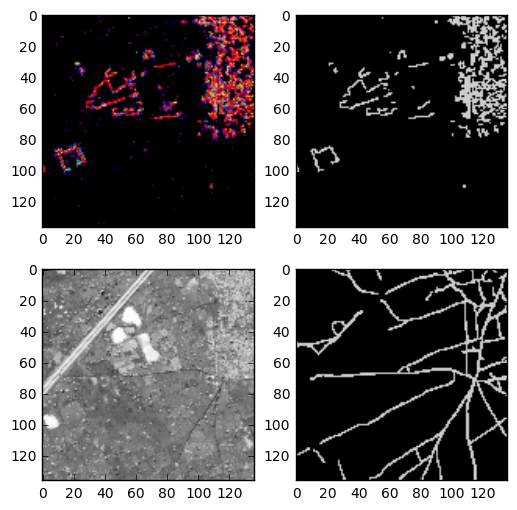

In [13]:
norm = False
if norm:
    preds = norm_preds(preds)

plot_all(8,3)
#push('Images are ready','Go look!')

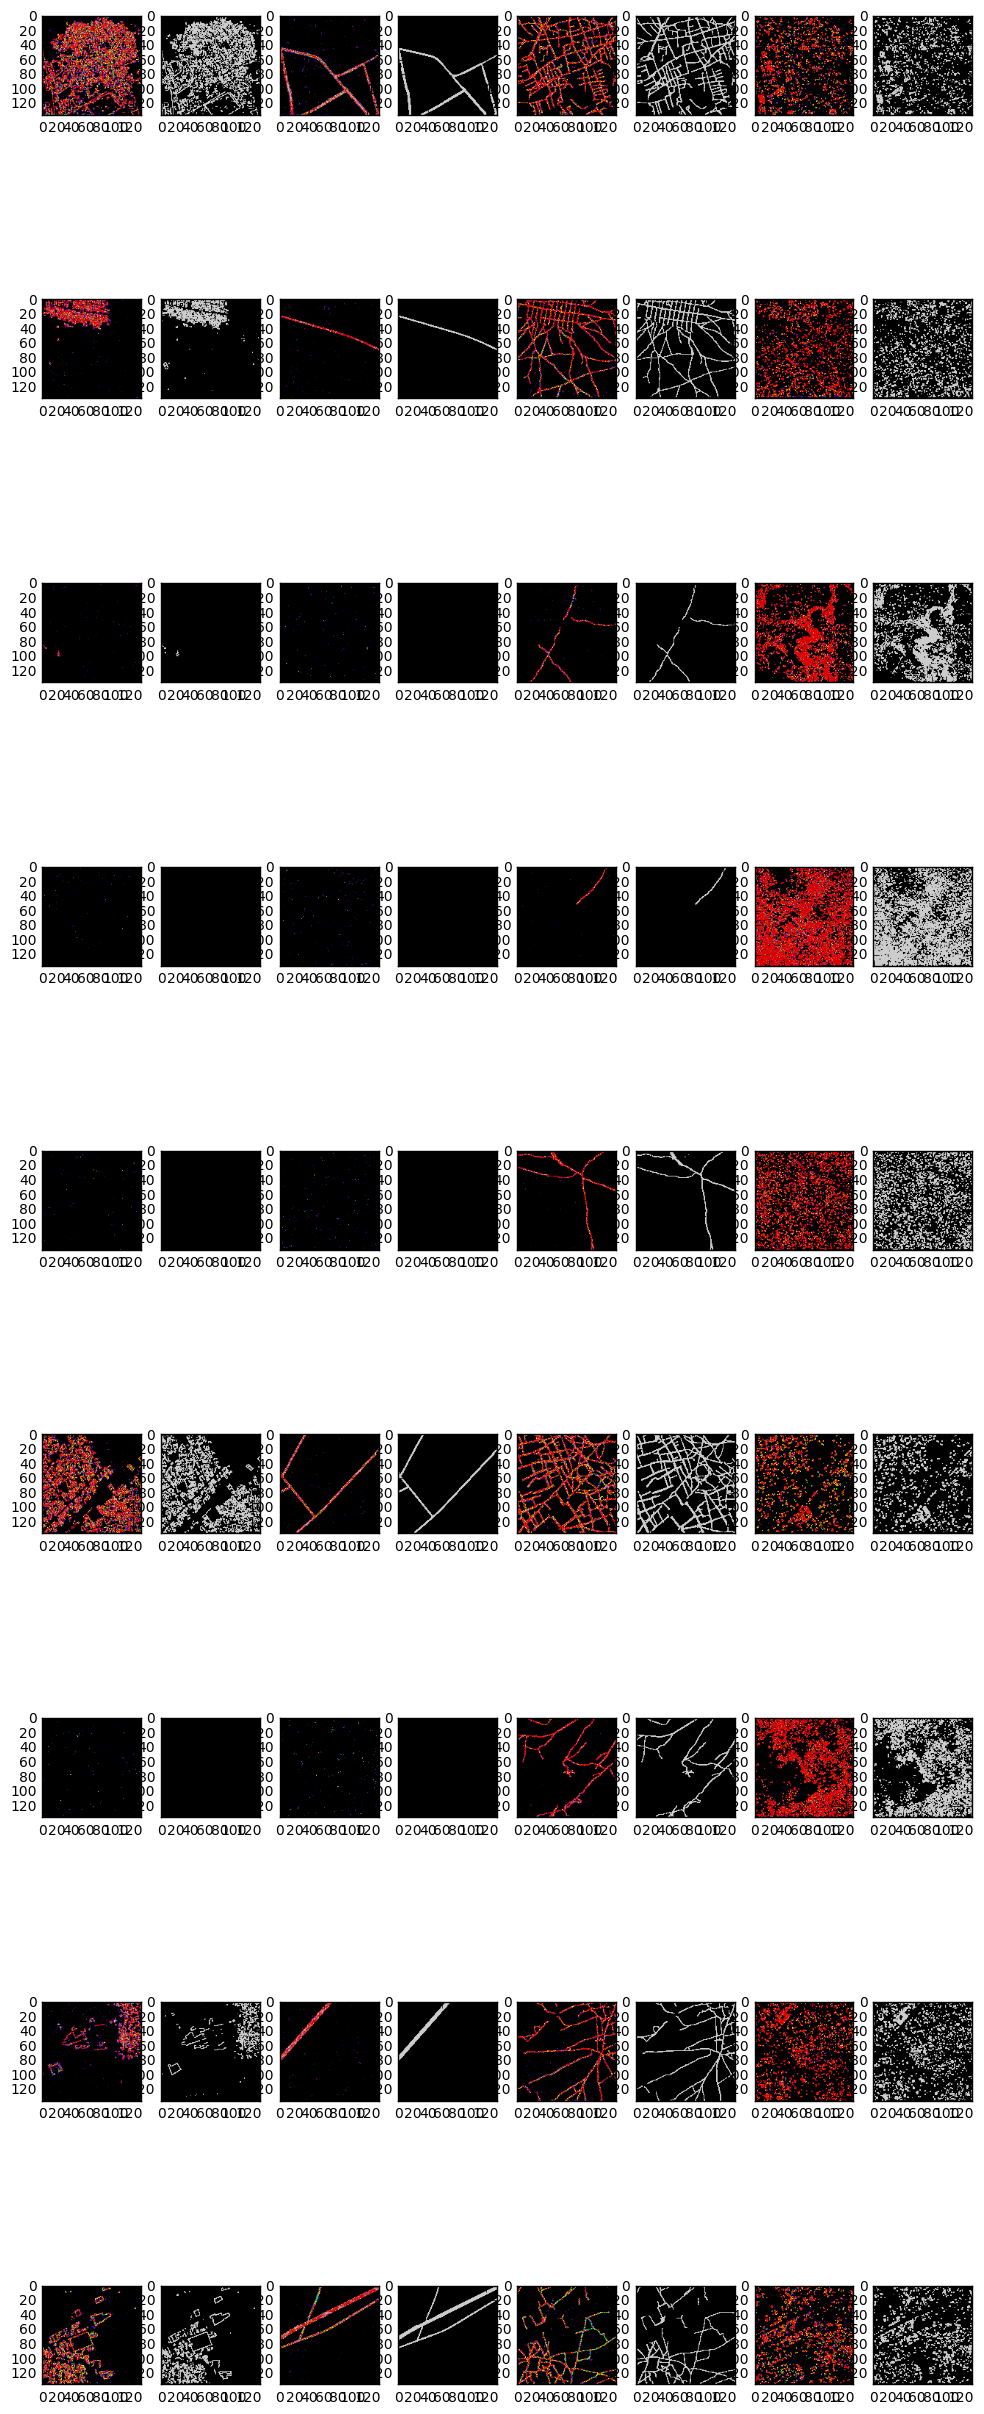

In [15]:
def plot_everything():
    fig = plt.figure(figsize=(12,36))
    #num = np.random.randint(10,25,10)
    num = np.arange(0,10)
    for i in range(1,10):
        ax1 = fig.add_subplot(10,8,8*i-7)
        ax1.imshow(preds[num[i],0,...],cmap='spectral')
        
        ax2 = fig.add_subplot(10,8,8*i-6)
        ax2.imshow(y_oneclass[num[i],0,...],cmap='spectral')
        
        ax3 = fig.add_subplot(10,8,8*i-5)
        ax3.imshow(preds[num[i],1,...],cmap='spectral')
        
        ax4 = fig.add_subplot(10,8,8*i-4)
        ax4.imshow(y_oneclass[num[i],1,...],cmap='spectral')
        
        ax5 = fig.add_subplot(10,8,8*i-3)
        ax5.imshow(preds[num[i],2,...],cmap='spectral')
        
        ax6 = fig.add_subplot(10,8,8*i-2)
        ax6.imshow(y_oneclass[num[i],2,...],cmap='spectral')
        
        ax7 = fig.add_subplot(10,8,8*i-1)
        ax7.imshow(preds[num[i],3,...],cmap='spectral')
        
        ax8 = fig.add_subplot(10,8,8*i)
        ax8.imshow(y_oneclass[num[i],3,...],cmap='spectral')
        
    plt.show()
plot_everything()

In [29]:
preds = model.predict(x)

In [23]:
model.evaluate(x[10:,...],y_oneclass[10:,...])

15/15 [==============================] - 91s


[0.4784470796585083, 0.22115007042884827]

In [27]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
np.mean([np_jaccard(x[i,...],preds[i,...]) for i in range(10)])

0.14514642154417759

In [10]:
def load_cancelled(model):
    model.load_weights('./data/unet.hdf5')
    imgs_mask_test = model.predict(x[:10,:,:,:], verbose=1)
    return imgs_mask_test

preds = load_cancelled(model)

10/10 [==============================] - 9s


In [ ]:
# Test the jaccard cost function
other_jaccard(y[:,3,:,:],training_outcomes)

In [ ]:
vars(model.history)

In [ ]:
plot_classifier(model)

In [39]:
def plot_classifier(model):
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(111)
    ax.plot(model.history.history['loss'], "-",color='blue',label="Training final loss: "+str(round(model.history.history['loss'][-1],4)))
    ax.plot(model.history.history['jaccard'], "-",color='orange',label="testing final loss: "+str(round(model.history.history['jaccard'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Jaccard / Loss')
    plt.legend(loc='best')
    ax.set_title('Metrics vs time (epochs)')
    
    '''ax = fig.add_subplot(122)
    ax.plot(model.history['acc'], "-",color='blue',label="Training final acc: "+str(round(model.history['acc'][-1],4)))
    ax.plot(model.history['val_acc'], "-",color='orange',label="testing final acc: "+str(round(model.history['val_acc'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='best')
    ax.set_title('Accuracy vs time (epochs)')    
    '''
    plt.show()

### Defunct bits and pieces

In [8]:
'''
Execute this in order to use a data generator to expand the number of images.
Note: adjust the variables to actually create random images
'''

datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(x)

### Gridsearch

In [ ]:
# define the grid search parameters
#np.random.randint(low,high,size)
lr = [10 ** np.random.randint(-10,-1)]
decay = np.random.random(10)
params = dict(lr=lr, decay=decay)
classType = 3

'''
KerasClassifier takes model parameters: i.e. arguments of build_fn, 
and fitting parameters, which would have been passed to model.fit()
'''
early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
jaccard = make_scorer(other_jaccard)
model = KerasRegressor(build_fn=builder,
                batch_size=1, nb_epoch=10, verbose=1, shuffle=True,
                nfilters = 4, activation = 'relu', init = 'he_normal', lr=1e-5, decay=0.99)
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_jobs=7,verbose=2,scoring=jaccard)
grid_result = grid.fit(x[5:8,:3,:,:], y[5:8,classType,np.newaxis,:,:])
push('Random search is done','Best score = %f' %grid_result.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Summarize results from gridsearch

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# I don't recall what this is...
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p

In [35]:
'''
Original U-Net without batch norm
'''

def builder(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1e-5,decay=0.99):
    
    def dice_coef(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    def jaccard(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true * y_pred)
        return (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)

    def jaccard_loss(y_true, y_pred):
        return -jaccard(y_true, y_pred)
    
    
    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(28,28))(inputs)
    
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(padded)
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(pool1)
    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(pool2)
    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(pool3)
    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(pool4)
    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(up6)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(up7)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(up8)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(up9)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid',init=init)(conv9)
    
    cropped = Cropping2D(cropping=((28,28), (28,28)))(conv10)
    model = Model(input=inputs, output=cropped)
    
    model.compile(optimizer=Adagrad(lr=lr,decay=decay), loss=jaccard_loss, metrics=[jaccard])
    
    return model
